In [1]:
import pandas as pd
X_train=pd.read_csv("../data/X_train_smote.csv")
X_test=pd.read_csv("../data/X_test_rfe.csv")
y_train=pd.read_csv("../data/y_train_smote.csv")
y_test=pd.read_csv("../data/y_test.csv")

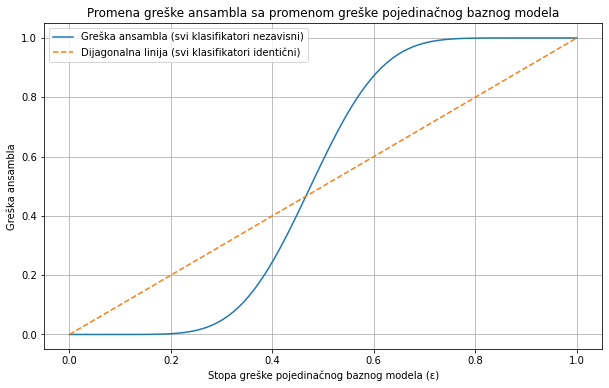

In [1365]:
import matplotlib.pyplot as plt
import numpy as np
from math import comb

# Definišemo opseg vrednosti za stopu greške pojedinačnog baznog modela 
epsilon_values = np.linspace(0, 1, 100)

# Definišemo funkciju za izračunavanje greške ansambla
def ensemble_error(epsilon):
    return sum([comb(20, i) * (epsilon**i) * ((1 - epsilon)**(20 - i)) for i in range(10, 21)])

# Računamo grešku ansambla za svaku vrednost ε
ensemble_errors = [ensemble_error(epsilon) for epsilon in epsilon_values]

# Crtamo grafik
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, ensemble_errors, label='Greška ansambla (svi klasifikatori nezavisni)')
plt.xlabel('Stopa greške pojedinačnog baznog modela (ε)')
plt.ylabel('Greška ansambla')
plt.plot(epsilon_values, epsilon_values, '--', label='Dijagonalna linija (svi klasifikatori identični)')
plt.title('Promena greške ansambla sa promenom greške pojedinačnog baznog modela')
plt.legend()
plt.grid(True)
plt.savefig('ansambl_greska.png')
plt.show()


# BAGGING

In [1352]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [1353]:
param_grid_tree={
    'max_depth' : [3,4],
    'min_samples_split':[6,7,8],
    'min_samples_leaf':[6,7,8],
    'criterion':['gini','entropy']
}

In [1354]:
from sklearn.utils import resample

In [1355]:
#forming bootstrap set for each base estimator
n_estimators=5
bootstrap_sets=[]
for i in range(n_estimators):
    bootstrap_indices=resample(range(len(X_train)),replace=True,random_state=i)
    bootstrap_sets.append((X_train.iloc[bootstrap_indices],y_train.iloc[bootstrap_indices]))

In [1356]:
base_estimators=[]
for i in range(n_estimators):
    model=GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=param_grid_tree,cv=5,scoring='accuracy')
    model.fit(bootstrap_sets[i][0],bootstrap_sets[i][1])
    base_estimators.append(model.best_estimator_)

In [1357]:
for estimator in base_estimators:
    print('max_depth:',estimator.get_params()['max_depth'],'min_samples_split:',estimator.get_params()['min_samples_split'],'min_samples_leaf:',estimator.get_params()['min_samples_leaf'],'criterion:',estimator.get_params()['criterion'])

max_depth: 3 min_samples_split: 6 min_samples_leaf: 7 criterion: entropy
max_depth: 4 min_samples_split: 8 min_samples_leaf: 7 criterion: gini
max_depth: 4 min_samples_split: 6 min_samples_leaf: 6 criterion: entropy
max_depth: 4 min_samples_split: 6 min_samples_leaf: 6 criterion: entropy
max_depth: 4 min_samples_split: 6 min_samples_leaf: 8 criterion: entropy


In [1358]:
final_predictions=[]
for j in range(len(X_train)):
    predictions=[]
    for i,estimator in enumerate(base_estimators):
        prediction=estimator.predict(X_train.iloc[j:j+1])
        predictions.append(prediction)
        
    final_prediction=voting(predictions)
    final_predictions.append(final_prediction)

In [1359]:
import numpy as np
def voting(predictions):
    unique, counts = np.unique(predictions, return_counts=True)
    most_common_prediction = unique[np.argmax(counts)]
    return most_common_prediction

In [1360]:
accuracy_score(y_train,final_predictions)

0.8406593406593407

In [1361]:
final_predictions=[]
for j in range(len(X_test)):
    predictions=[]
    for i,estimator in enumerate(base_estimators):
        prediction=estimator.predict(X_test.iloc[j:j+1])
        predictions.append(prediction)
        
    final_prediction=voting(predictions)
    final_predictions.append(final_prediction)

In [1362]:
accuracy_score(y_test,final_predictions)

0.7428571428571429

In [1363]:
f1_toxic = f1_score(y_test, final_predictions, pos_label="Toxic")
f1_nontoxic = f1_score(y_test, final_predictions, pos_label="NonToxic")
print(f1_nontoxic)
print(f1_toxic)

0.816326530612245
0.5714285714285713


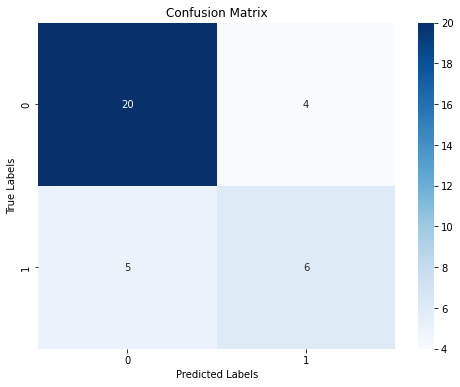

In [1364]:
import seaborn as sns
confusion=confusion_matrix(y_test,final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

N=1 TRENING 0.71 TEST 0.66
N=3 TRENING: 0.79,0.79,0.79,0.80,0.78,0.79,0.78,0.8,0.79,0.78,0.8,0.79,0.8 -> 0.79
    TEST   : 0.74,0.69,0.74,0.69,0.68,0.69,0.69,0.74,0.69,0.74,0.74,0.74,0.69-> 0.71
    
N=5 TRENING: 0.84,0.85,0.85,0.84,0.74,0.84,0.85,0.84,0.84,0.84,0.84,0.84,0.84  -> 0.83
    TEST:    0.71,0.77,0.74,0.71,0.71,0.71,0.77,0.71,0.71,0.74,0.74,0.74,0.74  -> 0.74

N=7 TRENING: 0.84, 0.85, 0.86, 0.84
    TEST:    0.74, 0.74, 0.74, 0.74

N=9 TRENING: 0.86, 0.86, 0.86, 0.85
    TEST   : 0.66, 0.66, 0.69, 0.69
N=11 TRENING: 0.85
     TEST   : 0.66

In [633]:
import statistics
statistics.mean([0.71,0.77,0.74,0.71,0.71,0.71,0.77,0.71,0.71,0.74,0.74,0.74,0.74])

0.7307692307692307

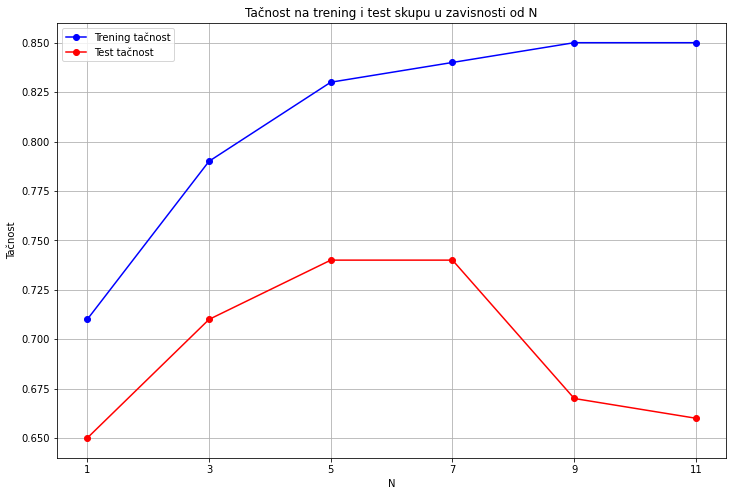

In [634]:
N_values = [1, 3, 5, 7, 9, 11]

# Tačnosti na trening skupu
train_accuracies = [0.71, 0.79, 0.83, 0.84, 0.85, 0.85]  

# Tačnosti na test skupu
test_accuracies = [0.65, 0.71, 0.74, 0.74, 0.67, 0.66]  

# Prikazivanje tačnosti na grafiku
plt.figure(figsize=(12, 8))
plt.plot(N_values, train_accuracies, marker='o', label='Trening tačnost', color='blue')
plt.plot(N_values, test_accuracies, marker='o', label='Test tačnost', color='red')
plt.title('Tačnost na trening i test skupu u zavisnosti od N')
plt.xlabel('N')
plt.ylabel('Tačnost')
plt.legend(loc='upper left')
plt.savefig('bagging_accuracy.png',transparent=True)
plt.legend()
plt.grid(True)
plt.xticks(N_values)
plt.show()

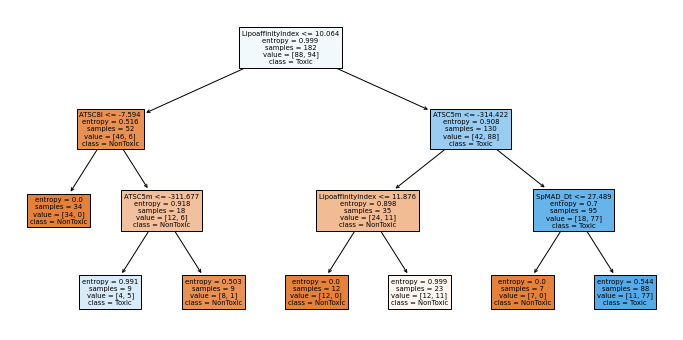

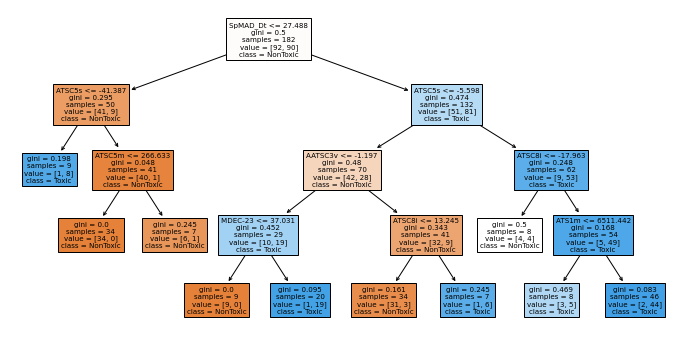

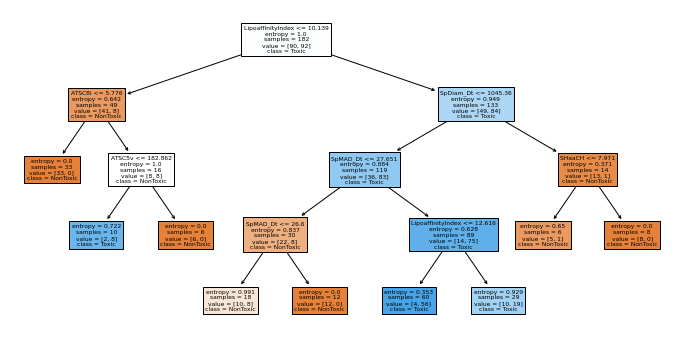

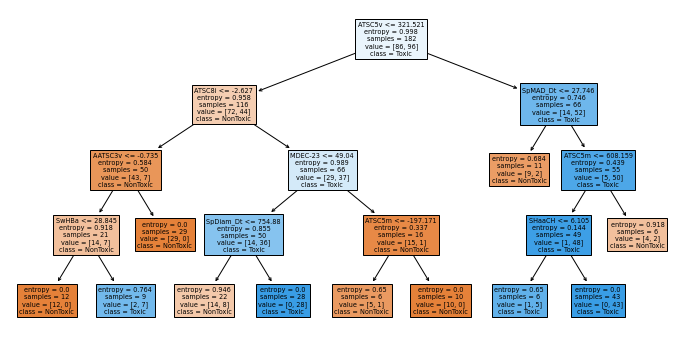

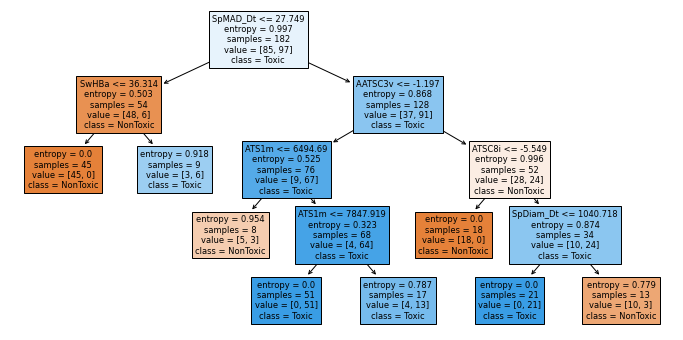

In [635]:
from sklearn.tree import  plot_tree
for i,estimator in enumerate (base_estimators):
    plt.figure(figsize=(12, 6))
    plot_tree(estimator, filled=True, feature_names=X_train.columns, class_names=['NonToxic','Toxic'])
    plt.savefig(f"tree_{i}.png")
    

# BOOSTING - ADA BOOST


In [639]:
from sklearn.ensemble import AdaBoostClassifier

In [640]:
base_model = DecisionTreeClassifier(max_depth=3)

In [641]:
adaboost_classifier = AdaBoostClassifier(base_model, n_estimators=5, random_state=42)

In [643]:
adaboost_classifier.fit(X_train, y_train.to_numpy().ravel())

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=5, random_state=42)

In [644]:
y_pred = adaboost_classifier.predict(X_test)

In [645]:
accuracy_score(y_test, y_pred)


0.6

In [648]:
estimators=adaboost_classifier.estimators_
for estimator in estimators:
    print(estimator.get_params())

{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1608637542, 'splitter': 'best'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1273642419, 'splitter': 'best'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 1935803228, 'splitter': 'best'}
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 

### ada boost with base estimators with different params

In [1305]:
param_grid_boost={
    'max_depth' : [3,4],
    'min_samples_split':[8,10],
    'min_samples_leaf':[4,6,8],
    'criterion':['gini','entropy']
}

In [1306]:
from sklearn.preprocessing import LabelEncoder

# Pretvorite "Toxic" u 1 i "NonToxic" u 0 za y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.to_numpy().ravel())
y_train_encoded = 2 * y_train_encoded - 1
# Pretvorite "Toxic" u 1 i "NonToxic" u 0 za y_test
y_test_encoded = label_encoder.transform(y_test.to_numpy().ravel())
y_test_encoded = 2 * y_test_encoded - 1


In [1307]:
n_iterations=10
n_samples=len(X_train)
weights = np.ones(n_samples) / n_samples

base_models = []
for t in range(n_iterations):
    grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid_boost, cv=5)
    grid_search.fit(X_train, y_train_encoded, sample_weight=weights)
    model = grid_search.best_estimator_
    
    predictions = model.predict(X_train)
    
    weighted_error = np.sum(weights * (predictions != y_train_encoded)) / np.sum(weights)
    alpha = 0.5 * np.log((1 - weighted_error) / weighted_error)
    
    weights = weights * np.exp(-alpha * y_train_encoded * predictions)
    weights /= np.sum(weights)
    
    base_models.append((model, alpha))

In [1308]:
predictions = np.zeros(n_samples)
for model, alpha in base_models:
    predictions += alpha * model.predict(X_train)
    print('alfa:',alpha,'max_depth:',model.get_params()['max_depth'],'min_samples_split:',model.get_params()['min_samples_split'],'min_samples_leaf:',model.get_params()['min_samples_leaf'],'criterion:',model.get_params()['criterion'])
predictions=np.sign(predictions)

alfa: 0.7175422626446614 max_depth: 4 min_samples_split: 8 min_samples_leaf: 8 criterion: entropy
alfa: 0.7998368995295976 max_depth: 3 min_samples_split: 8 min_samples_leaf: 8 criterion: entropy
alfa: 0.7373153735403973 max_depth: 4 min_samples_split: 8 min_samples_leaf: 8 criterion: entropy
alfa: 0.6922546668826838 max_depth: 3 min_samples_split: 8 min_samples_leaf: 6 criterion: gini
alfa: 0.8002215158208538 max_depth: 4 min_samples_split: 8 min_samples_leaf: 8 criterion: gini
alfa: 0.3468468747524798 max_depth: 3 min_samples_split: 8 min_samples_leaf: 6 criterion: entropy
alfa: 0.7670724050491674 max_depth: 4 min_samples_split: 8 min_samples_leaf: 4 criterion: gini
alfa: 0.8230414714147641 max_depth: 4 min_samples_split: 8 min_samples_leaf: 4 criterion: entropy
alfa: 0.6974741081002832 max_depth: 3 min_samples_split: 8 min_samples_leaf: 4 criterion: gini
alfa: 0.8169276706514306 max_depth: 4 min_samples_split: 8 min_samples_leaf: 8 criterion: gini


In [1309]:
accuracy_score(predictions,y_train_encoded)


1.0

In [1310]:
predictions = np.zeros(len(X_test))
for model, alpha in base_models:
    predictions += alpha * model.predict(X_test)
predictions=np.sign(predictions)
predictions

array([ 1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1., -1.,  1., -1.,
       -1., -1., -1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
        1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [1311]:
accuracy_score(predictions,y_test_encoded)


0.6

In [1312]:
f1_toxic = f1_score(predictions, y_test_encoded, pos_label=1)
f1_nontoxic = f1_score(predictions,y_test_encoded, pos_label=-1)
print(f1_toxic)
print(f1_nontoxic)

0.36363636363636365
0.7083333333333334


# Random Forest


In [1222]:
param_grid_rf={
    'max_depth' : [10,15,20],
    'min_samples_split':[3,5,10],
    'min_samples_leaf':[3,5,10],
    'criterion':['gini','entropy'],
    'max_features':['sqrt','auto','log2']
}

In [1320]:
n_estimators = 3
test_predictions = []
train_predictions = []

for i in range(n_estimators):
    #choosing bootstrap set for each estimator
    bootstrap_indices=resample(range(len(X_train)),replace=True,random_state=i)
    X_bootstrap = X_train.iloc[bootstrap_indices]
    y_bootstrap = y_train.iloc[bootstrap_indices]
    
    #building a base estimator
    model=GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=param_grid_rf,cv=5,scoring='accuracy')
    #model=DecisionTreeClassifier(max_features="sqrt")
    model.fit(X_bootstrap,y_bootstrap)
    
    estimator=model.best_estimator_
    #estimator=model
    print('max_features:',estimator.get_params()['max_features'],'max_depth:',estimator.get_params()['max_depth'],'min_samples_split:',estimator.get_params()['min_samples_split'],'min_samples_leaf:',estimator.get_params()['min_samples_leaf'],'criterion:',estimator.get_params()['criterion'])
    
    #making predictions on test instances
    predictions = estimator.predict(X_test)
    test_predictions.append(predictions)
    
    #making predictions on train instances
    predictions = estimator.predict(X_train)
    train_predictions.append(predictions)

max_features: log2 max_depth: 15 min_samples_split: 3 min_samples_leaf: 5 criterion: entropy
max_features: sqrt max_depth: 20 min_samples_split: 10 min_samples_leaf: 3 criterion: entropy
max_features: log2 max_depth: 15 min_samples_split: 10 min_samples_leaf: 3 criterion: gini


In [1321]:
final_predictions=[]
for j in range(len(X_train)):
    pred=[]
    for i in range(n_estimators):
        pred.append(train_predictions[i][j])
    final_prediction=voting(pred)
    final_predictions.append(final_prediction)
accuracy_score(y_train,final_predictions)

0.9340659340659341

In [1322]:
final_predictions=[]
for j in range(len(X_test)):
    pred=[]
    for i in range(n_estimators):
        pred.append(test_predictions[i][j])
    final_prediction=voting(pred)
    final_predictions.append(final_prediction)
accuracy_score(y_test,final_predictions)

0.6571428571428571

# bagging unbalansed data


In [1341]:
X_train=pd.read_csv('C:/Users/KORISNIK/Desktop/za fakultet/ToxicityOfMolecules/data/X_train_rfe.csv')
X_test=pd.read_csv('C:/Users/KORISNIK/Desktop/za fakultet/ToxicityOfMolecules/data/X_test_rfe.csv')
y_train=pd.read_csv('C:/Users/KORISNIK/Desktop/za fakultet/ToxicityOfMolecules/data/y_train.csv')
y_test=pd.read_csv('C:/Users/KORISNIK/Desktop/za fakultet/ToxicityOfMolecules/data/y_test.csv')

In [1342]:
n_estimators=5
bootstrap_sets=[]
for i in range(n_estimators):
    bootstrap_indices=resample(range(len(X_train)),replace=True,random_state=i)
    bootstrap_sets.append((X_train.iloc[bootstrap_indices],y_train.iloc[bootstrap_indices]))

In [1343]:
base_estimators=[]
for i in range(n_estimators):
    model=GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=param_grid_tree,cv=5,scoring='accuracy')
    model.fit(bootstrap_sets[i][0],bootstrap_sets[i][1])
    base_estimators.append(model.best_estimator_)

In [1344]:
for estimator in base_estimators:
    print('max_depth:',estimator.get_params()['max_depth'],'min_samples_split:',estimator.get_params()['min_samples_split'],'min_samples_leaf:',estimator.get_params()['min_samples_leaf'],'criterion:',estimator.get_params()['criterion'])

max_depth: 4 min_samples_split: 7 min_samples_leaf: 6 criterion: entropy
max_depth: 4 min_samples_split: 8 min_samples_leaf: 6 criterion: gini
max_depth: 4 min_samples_split: 7 min_samples_leaf: 6 criterion: gini
max_depth: 4 min_samples_split: 6 min_samples_leaf: 8 criterion: entropy
max_depth: 4 min_samples_split: 7 min_samples_leaf: 6 criterion: entropy


In [1345]:
final_predictions=[]
for j in range(len(X_train)):
    predictions=[]
    for i,estimator in enumerate(base_estimators):
        prediction=estimator.predict(X_train.iloc[j:j+1])
        predictions.append(prediction)
        
    final_prediction=voting(predictions)
    final_predictions.append(final_prediction)

In [1346]:
accuracy_score(y_train,final_predictions)

0.8602941176470589

In [1347]:
final_predictions=[]
for j in range(len(X_test)):
    predictions=[]
    for i,estimator in enumerate(base_estimators):
        prediction=estimator.predict(X_test.iloc[j:j+1])
        predictions.append(prediction)
        
    final_prediction=voting(predictions)
    final_predictions.append(final_prediction)

In [1348]:
accuracy_score(y_test,final_predictions)

0.6857142857142857

In [1349]:
f1_toxic = f1_score(y_test, final_predictions, pos_label="Toxic")
f1_nontoxic = f1_score(y_test, final_predictions, pos_label="NonToxic")
print(f1_nontoxic)
print(f1_toxic)

0.7924528301886793
0.3529411764705882
